# Walmart Recruiting II: Sales in Stormy Weather
<img src="https://3blaws.s3.amazonaws.com/images/wmt_h_r_c.jpg" alt="Walmart Logo" title="Walmart Logo" />
## Project Overview
> From https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather

Walmart operates 11,450 stores in 27 countries, managing inventory across varying climates and cultures. Extreme weather events, like hurricanes, blizzards, and floods, can have a huge impact on sales at the store and product level. 

In their second Kaggle recruiting competition, Walmart challenges participants to accurately predict the sales of 111 potentially weather-sensitive products (like umbrellas, bread, and milk) around the time of major weather events at 45 of their retail locations. 

Intuitively, we may expect an uptick in the sales of umbrellas before a big thunderstorm, but it's difficult for replenishment managers to correctly predict the level of inventory needed to avoid being out-of-stock or overstock during and after that storm. Walmart relies on a variety of vendor tools to predict sales around extreme weather events, but it's an ad-hoc and time-consuming process that lacks a systematic measure of effectiveness. 

Helping Walmart better predict sales of weather-sensitive products will keep valued customers out of the rain. It could also earn you a position at one of the most data-driven retailers in the world! 

Please note: You must compete as an individual in recruiting competitions. You may only use the data provided to make your predictions.

## Dataset Description
### File Descriptions

- key.csv - the relational mapping between stores and the weather stations that cover them
- sampleSubmission.csv - file that gives the prediction format
- train.csv - sales data for all stores & dates in the training set
- test.csv - stores & dates for forecasting (missing 'units', which you must predict)  NOTE: This file has been encrypted. To get the password, please fill out Walmart's Recruiting Survey
- weather.csv - a file containing the NOAA weather information for each station and day
- noaa_weather_qclcd_documentation.pdf - a guide to understand the data provided in the weather.csv file

### Data Field Descriptions

- date - the day of sales or weather
- store_nbr - an id representing one of the 45 stores
- station_nbr - an id representing one of 20 weather stations
- item_nbr - an id representing one of the 111 products
- units - the quantity sold of an item on a given day
- id - a triplet representing a store_nbr, item_nbr, and date. Form the id by concatenating these (in that order) with an underscore. E.g. "2_1_2013-04-01" represents store 2, item 1, sold on 2013-04-01.

# Introduction
To forecast the number of sales for items given store location and date of sale, Walmart has provided two sets of data: weather data and historical sales data. The host of the competition places a special emphasis on basing predictions on weather data, however in my approach, I chose to generate predictions solely on historical sales data, only choosing to incorporate weather data if I was unsatisfied with the results of my initial model. My reason for prioritizing historic sales data is that 1) I assume that the effect of weather on "potentially" weather-sensitive items is actually low to none and 2) introducing weather data may create noise in building a sales model. Ulitmately, my intuition of using historical sales data alone was right on the money as my final model scores a 0.09279 on the Root Mean Squared Logarithmic Error (RMSLE) scale: the best score in the competition.

A breakdown of my strategy on this winning score is as follows:
1. Do Exploratory Data Analysis in Tableau: EDA showed that most of the store/item pairs in the training data had no sales.
2. Filter out store/item pairs with no sales in both train and test datsets. Store/item pairs in test dataset with no historical sales in training set will be predicted as no sales. Store/item pairs in test dataset with historical sales will be predicted with features generated from store/item pairs in filtered training set.
3. Generate features based on date and store/item ids.
4. Train and tune model.
5. Generate and submit predictions.

# Notebook Contents
## Part I: Data Clean-up and Exploratory Data Analysis
## Part II: Feature Generation
## Part III: Model Testing and Optimization
## Part IV: Discussion of Results

# Part I: Data Clean-up and Exploratory Data Analysis

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from datetime import date
import calendar
from pandas.tseries.holiday import USFederalHolidayCalendar
import datetime
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/Sean/anaconda3/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read in csvs
train_raw=pd.read_csv('datasets/train.csv')
test_raw=pd.read_csv('datasets/test.csv')
sample=pd.read_csv('datasets/sampleSubmission.csv')

In [3]:
# create df for items never sold per store
never_sold=pd.DataFrame(train_raw.groupby(['store_nbr','item_nbr'])['units'].sum().sort_values()).reset_index()
never_sold=never_sold[never_sold.units==0]
never_sold['never_sold']=1
train_raw1=train_raw.merge(never_sold[['store_nbr','item_nbr','never_sold']],on=['store_nbr','item_nbr'],how='left')
# only keep units that had a sale/do EDA in tableau
train=train_raw1[train_raw1.never_sold!=1]
train=train.drop(columns=['never_sold'])
train.to_csv('datasets/train_cleaned.csv',index=False)

In [4]:
# create id for test_raw from sample submission
test_raw['id']=sample['id']
# filter test_raw for never sold items from training
test_raw1=test_raw.merge(never_sold[['store_nbr','item_nbr','never_sold']],on=['store_nbr','item_nbr'],how='left')
# also exlcude sales on christmas 2013 because minimal sales in training set
test=test_raw1[(test_raw1.never_sold!=1) & (test_raw1.date!='2013-12-25')]
test_has_sold_ids=test['id']
test=test[['date','store_nbr','item_nbr']]

## EDA Observations From Tableau
Elements in date are definitely useful. 2012 has the most sales and sales decrease until 2014. A feature relating to the 2012 year date will have to be excluded since test dataset only includes years 2013 to 2014. Sales tend to have a local dip in May and peak in September. Major holidays like Thanksgiving and Christmas are marked with the lowest sales in the year if Walmart was opened. Walmart only had 2 sales on Christmas of 2013. Sales peak on weekends. Some items tend to be immensely popular, items 45, 9, and 5, being the most popular. A tableau packaged workbook is contained within this repository. If you do not have Tableau installed, Tableau Reader is available for free and can be used to open this workbook to view the visualizations made.

# Part II: Feature Generation
Based on the observations from the visualization, features I will choose to generate will include:
1. Whether sale date as on a weekday/weekend
2. Whether sale date was on a holiday and +/- 1/2/3 and 7 days away from holiday
3. Store and item number dummy variables
4. Day of cycle, day of year, day of month, day of week sale was made

In [5]:
#merge train and test convert date to datetime
merged=pd.concat([train.drop(columns=['units']),test]).reset_index(drop=True)
merged['datetime']=pd.to_datetime(merged['date'])
merged['epoch_time']=merged['datetime'].apply(lambda x: x.timestamp())
#get sale_year,month,day
merged['sale_year']=merged['date'].apply(lambda x: int(x.split('-')[0]))
merged['sale_month']=merged['date'].apply(lambda x: int(x.split('-')[1]))
merged['sale_day']=merged['date'].apply(lambda x: int(x.split('-')[2]))
# day of year
merged['day_of_year']=merged['datetime'].apply(lambda x: x.timetuple().tm_yday)
# day of week
merged['day_of_week']=merged['datetime'].apply(lambda x: x.timetuple().tm_wday)
# day of cycle
merged['day_of_cycle']=merged['datetime'].apply(lambda x: (x-merged['datetime'][0]).days+1)

In [6]:
# determine day of week 
merged['weekday_name']=merged['datetime'].apply(lambda x: calendar.day_name[x.weekday()])
weekends=set(['Sunday','Saturday'])
merged['is_weekend']=merged['weekday_name'].apply(lambda x: 1 if x in weekends else 0)
merged['is_weekday']=merged['weekday_name'].apply(lambda x: 0 if x in weekends else 1)

In [7]:
#create dataframe of holidays
cal = USFederalHolidayCalendar()
more_holidays=['01/01/2012','04/08/2012','03/31/2013','04/20/2014','12/24/2012','12/24/2013','12/24/2014']
holidays_df=pd.concat([cal.holidays(start='2011-12-31', end='2014-12-31').to_frame().reset_index(drop=True),pd.DataFrame(more_holidays)]).apply(lambda x: pd.to_datetime(x)).reset_index(drop=True)
holidays_df=holidays_df.iloc[1:,:]

In [8]:
# mark holidays and x days away from holiday
holidays_list=set(holidays_df[0])
merged['on_holiday']=merged['datetime'].apply(lambda x: 1 if x in holidays_list else 0)

In [9]:
#within one day of holiday but not on holiday
holiday_1day=set(pd.concat([holidays_df.apply(lambda x: x + datetime.timedelta(days=1)),holidays_df.apply(lambda x: x + datetime.timedelta(days=-1))])[0])
merged['1d_away_holiday']=merged['datetime'].apply(lambda x: 1 if x in holiday_1day else 0)

#within 2 days of holiday
holiday_1day.update(pd.concat([holidays_df.apply(lambda x: x + datetime.timedelta(days=2)),holidays_df.apply(lambda x: x + datetime.timedelta(days=-2))])[0].tolist())
merged['2d_away_holiday']=merged['datetime'].apply(lambda x: 1 if x in holiday_1day else 0)

#within 3 days of holiday
holiday_1day.update(pd.concat([holidays_df.apply(lambda x: x + datetime.timedelta(days=3)),holidays_df.apply(lambda x: x + datetime.timedelta(days=-3))])[0].tolist())
merged['3d_away_holiday']=merged['datetime'].apply(lambda x: 1 if x in holiday_1day else 0)

#within 7 days of holiday
for d in [4,5,6,7]:
    holiday_1day.update(pd.concat([holidays_df.apply(lambda x: x + datetime.timedelta(days=d)),holidays_df.apply(lambda x: x + datetime.timedelta(days=-d))])[0].tolist())
merged['7d_away_holiday']=merged['datetime'].apply(lambda x: 1 if x in holiday_1day else 0)

In [10]:
#get dummies for categorical features store and item number
to_dummies_cols=['store_nbr','item_nbr']

#features that area already categorized (holiday features)
already_cat=list(merged)[-7:]

# create dummy variables
merged_dummies_df1=pd.get_dummies(merged[to_dummies_cols].applymap(str))
merged_dummies_df=merged_dummies_df1.copy()

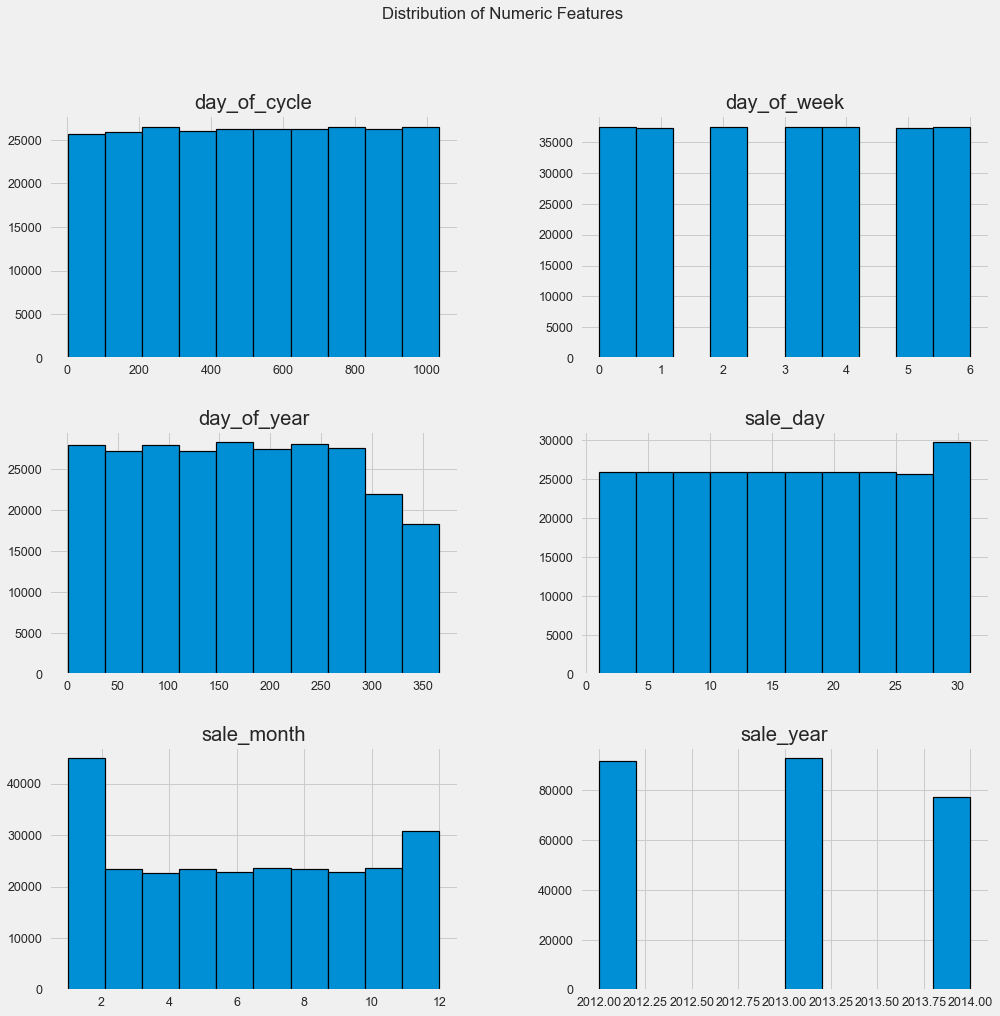

In [11]:
# plot distribution of numeric columns

sns.set(font_scale=1.25)
plt.style.use('fivethirtyeight')

num_columns=list(merged.iloc[:,5:11])
merged_num_df=merged[num_columns]

merged_num_df.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(15,15)
plt.suptitle("Distribution of Numeric Features")
plt.show()


 mu = 19.31 and sigma = 39.42



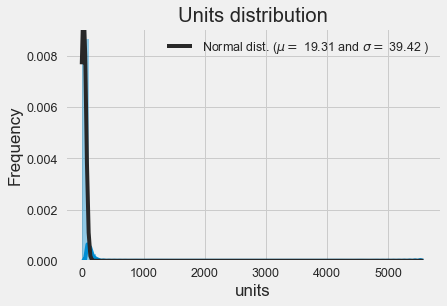

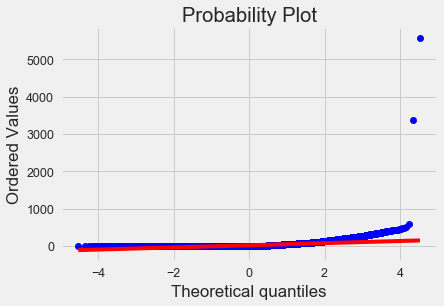

In [12]:
# distribution of units/target variable

sns.distplot(train['units'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['units'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Units distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['units'], plot=plt)
plt.show()


 mu = 1.48 and sigma = 1.76



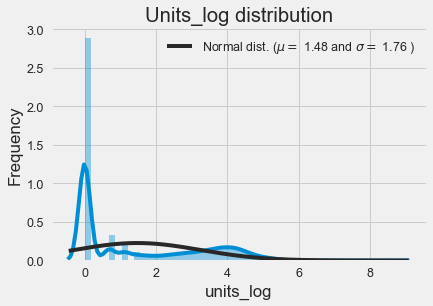

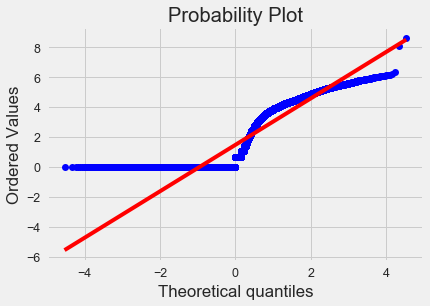

In [13]:
#log transform units
# may not actually benefit from log transforming/may use sqrt transform
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train.loc[:,'units_log']=train.loc[:,'units'].apply(lambda x: np.log1p(x))
train.loc[:,'units_sqrt']=train.loc[:,'units'].apply(lambda x: np.sqrt(x))


#Check the new units_log 
sns.distplot(train['units_log'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['units_log'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Units_log distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['units_log'], plot=plt)
plt.show()

In [14]:
#concatenate all features
all_features=pd.concat([merged_dummies_df,merged[already_cat],merged_num_df],axis=1)

#prescaled features df
prescaled_all_features=all_features.copy()

#scale

features_to_scale=all_features.columns.tolist()

for f in features_to_scale:
    all_features[f]=RobustScaler().fit_transform(all_features[f].as_matrix().reshape(-1,1)).flatten()

In [15]:
X=all_features[:len(train)]
Y=train['units_log'].reset_index(drop=True)

unk_features=all_features[len(train):]

#
train_complete=pd.concat([X,Y],axis=1)
print("Find most important features relative to target")
corr = train_complete.corr()
corr.sort_values(['units_log'], ascending=False, inplace=True)
print corr.units_log.head(10)
print corr.units_log[corr.units_log>-1].tail(10)

Find most important features relative to target
units_log       1.000000
item_nbr_45     0.394143
item_nbr_5      0.350246
item_nbr_9      0.323656
item_nbr_44     0.256378
item_nbr_16     0.187482
item_nbr_68     0.162989
item_nbr_37     0.123439
item_nbr_25     0.109008
store_nbr_17    0.106230
Name: units_log, dtype: float64
item_nbr_49    -0.085324
item_nbr_85    -0.086196
item_nbr_84    -0.090366
item_nbr_51    -0.094612
item_nbr_104   -0.101375
item_nbr_15    -0.103148
item_nbr_50    -0.106271
item_nbr_105   -0.124378
item_nbr_86    -0.134380
item_nbr_93    -0.243325
Name: units_log, dtype: float64


In [16]:
#drop sale_year_2012 because not in unknown features
#all_features1=all_features.drop(columns=['sale_year_2012'])
X=all_features[:len(train)]
# log transformed units
Y=train['units_log'].reset_index(drop=True)
# square transformed units
Y_sqrt=train['units_sqrt'].reset_index(drop=True)
# raw units
Y_raw=train['units'].reset_index(drop=True)

#unknown features
unk_features=all_features[len(train):]
unk_ids=test_has_sold_ids

#outliers revemoved
#Y.reset_index(drop=True).sort_values(ascending=False)
outliers_index=[80333,162941]
Y_out=Y.reset_index(drop=True)
X_out=X[~X.index.isin(outliers_index)]
Y_out=Y[~Y.index.isin(outliers_index)]
Y_out_sqrt=Y_sqrt[~Y_sqrt.index.isin(outliers_index)]

# Part III: Model Selection and Optimization
Having good results with tuned xgboost, I decided to try out how it would perform before hyperparameter tuning and after hyperparameter tuning. Before tuning the xgboost model returns a result of 0.15470 RMSLE. After tuning, the model returns a result of 0.09279 RMSLE: a score that beats all other scores on the leaderboard.

## Default XGBoost Predictions

In [17]:
# split training dataset into test train validation splits
X_train, X_test, y_train, y_test =train_test_split(X, Y, test_size=0.1, random_state=7)

In [18]:
#Validation function
n_folds = 5

#function to evaluate each model
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)#.get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv = kf, verbose=True))
    return(rmse)

In [19]:
# cross validation on RMSE score of untuned xgboost model
xgb = xg.XGBRegressor()
xgb.set_params(nthread = -1)
xgb.set_params(silent = False)
rmsle_cv(xgb)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.4min finished


array([ 0.70823369,  0.70882036,  0.7092397 ,  0.71415327,  0.70403555])

In [20]:
# using log transformed units with no tuning returns a score of 0.15470 RMSLE
xgb.fit(X,Y)
y_pred=xgb.predict(unk_features)
y_pred = np.expm1(y_pred)
xgb_preds=pd.DataFrame({'id':unk_ids,'units':y_pred})
xgb_preds.describe()

,units
count,26162.000000
mean,11.346739
std,18.128374
min,0.362158
25%,0.713682
50%,0.713682
75%,19.595774
max,111.958260


In [21]:
# using sqrt transformed units with no tuning returns a score of 0.14343 RMSLE
xgb.fit(X_out,Y_out_sqrt)
y_pred=xgb.predict(unk_features)
y_pred = y_pred**2
xgb_preds=pd.DataFrame({'id':unk_ids,'units':y_pred})
xgb_preds.describe()

,units
count,26162.000000
mean,14.559010
std,24.820272
min,0.179852
25%,0.558115
50%,0.623325
75%,24.548159
max,185.744385


## Tuned XGBoost Predictions

In [22]:
# step 1: determine the best number of trees with high learning rate and n_estimators

xgtrain = xg.DMatrix(X.values, label=Y.values)
clf = xg.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='reg:linear',
 nthread=-1,
 scale_pos_weight=1,
 seed=27)

xgb_param = clf.get_xgb_params()

cvresult = xg.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=5, metrics=['rmse'],
     early_stopping_rounds=50, stratified=True, seed=27,verbose_eval=True)
print('Best number of trees = {}'.format(cvresult.shape[0]))

/Users/Sean/anaconda3/lib/python2.7/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


[0]	train-rmse:1.88104+0.0133185	test-rmse:1.88072+0.0107848
[1]	train-rmse:1.76642+0.0138183	test-rmse:1.76621+0.0121153
[2]	train-rmse:1.6768+0.0193563	test-rmse:1.67634+0.0174754
[3]	train-rmse:1.59164+0.0138016	test-rmse:1.59128+0.0134478
[4]	train-rmse:1.51611+0.0103785	test-rmse:1.51572+0.0074456
[5]	train-rmse:1.44745+0.0153488	test-rmse:1.44712+0.0134805
[6]	train-rmse:1.38587+0.0168823	test-rmse:1.38555+0.0164099
[7]	train-rmse:1.32906+0.0100262	test-rmse:1.32887+0.0117588
[8]	train-rmse:1.28292+0.0138749	test-rmse:1.28286+0.0146989
[9]	train-rmse:1.23637+0.0110469	test-rmse:1.23633+0.0114935
[10]	train-rmse:1.19863+0.0120207	test-rmse:1.19841+0.0106094
[11]	train-rmse:1.16462+0.0119194	test-rmse:1.16467+0.0105473
[12]	train-rmse:1.12951+0.00912436	test-rmse:1.12964+0.00782941
[13]	train-rmse:1.10239+0.0106191	test-rmse:1.10236+0.00910142
[14]	train-rmse:1.07522+0.00843111	test-rmse:1.07539+0.00695303
[15]	train-rmse:1.0507+0.00678902	test-rmse:1.05092+0.00597704
[16]	train-rm

[126]	train-rmse:0.552807+0.00129647	test-rmse:0.556339+0.00125375
[127]	train-rmse:0.551702+0.00150498	test-rmse:0.5552+0.00115673
[128]	train-rmse:0.551088+0.00159468	test-rmse:0.554599+0.00107246
[129]	train-rmse:0.550267+0.00155222	test-rmse:0.553778+0.00129343
[130]	train-rmse:0.549207+0.00131736	test-rmse:0.552734+0.00152391
[131]	train-rmse:0.548309+0.00120837	test-rmse:0.551867+0.0017851
[132]	train-rmse:0.547555+0.00142469	test-rmse:0.551152+0.00169832
[133]	train-rmse:0.546628+0.00127923	test-rmse:0.550279+0.00157954
[134]	train-rmse:0.545882+0.00107299	test-rmse:0.549549+0.00167747
[135]	train-rmse:0.545292+0.00103582	test-rmse:0.549003+0.00170278
[136]	train-rmse:0.544432+0.000828774	test-rmse:0.54818+0.00168956
[137]	train-rmse:0.543112+0.000974341	test-rmse:0.546909+0.00251293
[138]	train-rmse:0.54243+0.00114961	test-rmse:0.546269+0.00253425
[139]	train-rmse:0.541874+0.00123339	test-rmse:0.54571+0.00260831
[140]	train-rmse:0.541042+0.00117716	test-rmse:0.544885+0.0023999


[249]	train-rmse:0.495248+0.00122427	test-rmse:0.50168+0.00183839
[250]	train-rmse:0.494966+0.00122209	test-rmse:0.501417+0.00193393
[251]	train-rmse:0.494679+0.0013883	test-rmse:0.501156+0.00193386
[252]	train-rmse:0.49442+0.00145501	test-rmse:0.500937+0.00198132
[253]	train-rmse:0.494176+0.00142231	test-rmse:0.500709+0.00201618
[254]	train-rmse:0.493872+0.00133105	test-rmse:0.5004+0.00209685
[255]	train-rmse:0.493482+0.00117555	test-rmse:0.499998+0.00210942
[256]	train-rmse:0.493215+0.00111187	test-rmse:0.499768+0.0021836
[257]	train-rmse:0.492745+0.00151744	test-rmse:0.499338+0.00189667
[258]	train-rmse:0.492414+0.00153938	test-rmse:0.499024+0.00197425
[259]	train-rmse:0.492188+0.00158489	test-rmse:0.498803+0.00192474
[260]	train-rmse:0.491904+0.00153961	test-rmse:0.498548+0.00192636
[261]	train-rmse:0.491394+0.00143439	test-rmse:0.498066+0.00190756
[262]	train-rmse:0.491091+0.00163544	test-rmse:0.497776+0.00182712
[263]	train-rmse:0.49087+0.00161214	test-rmse:0.497573+0.00183558
[2

[373]	train-rmse:0.467985+0.00134803	test-rmse:0.477162+0.0017646
[374]	train-rmse:0.467821+0.00140575	test-rmse:0.477022+0.00172923
[375]	train-rmse:0.467679+0.00144776	test-rmse:0.476904+0.00173837
[376]	train-rmse:0.467487+0.00140423	test-rmse:0.476728+0.00176681
[377]	train-rmse:0.467318+0.0014086	test-rmse:0.476583+0.00172402
[378]	train-rmse:0.467223+0.00139992	test-rmse:0.476501+0.00172938
[379]	train-rmse:0.466986+0.00127036	test-rmse:0.476289+0.00183068
[380]	train-rmse:0.466841+0.00128202	test-rmse:0.476177+0.00180672
[381]	train-rmse:0.466668+0.00128762	test-rmse:0.476044+0.00178476
[382]	train-rmse:0.466541+0.0012272	test-rmse:0.475929+0.001828
[383]	train-rmse:0.466435+0.00121979	test-rmse:0.47584+0.00184707
[384]	train-rmse:0.466282+0.00122191	test-rmse:0.475709+0.00185352
[385]	train-rmse:0.466136+0.00123493	test-rmse:0.475582+0.00185753
[386]	train-rmse:0.465984+0.00120601	test-rmse:0.475466+0.0018534
[387]	train-rmse:0.465795+0.00116616	test-rmse:0.475276+0.00192605
[3

[495]	train-rmse:0.45068+0.000771161	test-rmse:0.462709+0.00236114
[496]	train-rmse:0.450504+0.000746577	test-rmse:0.462557+0.00241588
[497]	train-rmse:0.450386+0.000784314	test-rmse:0.462467+0.00237739
[498]	train-rmse:0.450302+0.000788245	test-rmse:0.462425+0.00236961
[499]	train-rmse:0.450203+0.000770938	test-rmse:0.462344+0.00240148
[500]	train-rmse:0.450061+0.000782844	test-rmse:0.462228+0.00235752
[501]	train-rmse:0.449957+0.000754392	test-rmse:0.462145+0.00239031
[502]	train-rmse:0.449858+0.000754684	test-rmse:0.462074+0.00238747
[503]	train-rmse:0.449736+0.000779258	test-rmse:0.461964+0.00235633
[504]	train-rmse:0.449656+0.000784169	test-rmse:0.46191+0.00235239
[505]	train-rmse:0.449563+0.000789288	test-rmse:0.46184+0.00235087
[506]	train-rmse:0.449468+0.000793315	test-rmse:0.461769+0.00234776
[507]	train-rmse:0.449382+0.000773444	test-rmse:0.461708+0.00237157
[508]	train-rmse:0.449293+0.000763721	test-rmse:0.461639+0.00238582
[509]	train-rmse:0.44911+0.000774967	test-rmse:0.46

[617]	train-rmse:0.439092+0.000903787	test-rmse:0.454123+0.00259519
[618]	train-rmse:0.439002+0.000902984	test-rmse:0.454061+0.00259808
[619]	train-rmse:0.438916+0.000950261	test-rmse:0.453996+0.00255325
[620]	train-rmse:0.43885+0.000940242	test-rmse:0.453948+0.00258766
[621]	train-rmse:0.438797+0.000932173	test-rmse:0.45392+0.00259313
[622]	train-rmse:0.438731+0.000931925	test-rmse:0.453888+0.00258956
[623]	train-rmse:0.43865+0.000941091	test-rmse:0.453827+0.00258717
[624]	train-rmse:0.438576+0.00094778	test-rmse:0.45378+0.00257313
[625]	train-rmse:0.438477+0.000929686	test-rmse:0.453701+0.00258761
[626]	train-rmse:0.438394+0.000965562	test-rmse:0.453625+0.0025298
[627]	train-rmse:0.438318+0.000962245	test-rmse:0.453576+0.00254683
[628]	train-rmse:0.438254+0.000950021	test-rmse:0.453534+0.00255522
[629]	train-rmse:0.438127+0.000957037	test-rmse:0.453455+0.00255497
[630]	train-rmse:0.438078+0.000954967	test-rmse:0.453424+0.00255178
[631]	train-rmse:0.438025+0.000946666	test-rmse:0.4533

[740]	train-rmse:0.430431+0.0011553	test-rmse:0.448417+0.00265633
[741]	train-rmse:0.430388+0.00115975	test-rmse:0.448389+0.00264983
[742]	train-rmse:0.430325+0.00115898	test-rmse:0.448342+0.00263979
[743]	train-rmse:0.430258+0.00117532	test-rmse:0.448312+0.00262634
[744]	train-rmse:0.430207+0.00119512	test-rmse:0.448275+0.00259778
[745]	train-rmse:0.430149+0.00119037	test-rmse:0.448248+0.00260463
[746]	train-rmse:0.43009+0.00119329	test-rmse:0.448195+0.00262077
[747]	train-rmse:0.430031+0.00117305	test-rmse:0.448159+0.00263224
[748]	train-rmse:0.429979+0.00116571	test-rmse:0.448124+0.00264191
[749]	train-rmse:0.429923+0.00113352	test-rmse:0.448087+0.00265349
[750]	train-rmse:0.429861+0.00110967	test-rmse:0.448052+0.00265066
[751]	train-rmse:0.42981+0.00107628	test-rmse:0.448024+0.0026603
[752]	train-rmse:0.429743+0.0010432	test-rmse:0.447981+0.00268592
[753]	train-rmse:0.429682+0.00103856	test-rmse:0.447961+0.00269226
[754]	train-rmse:0.429619+0.00102481	test-rmse:0.447922+0.00269468


[863]	train-rmse:0.423657+0.000938805	test-rmse:0.444557+0.00269987
[864]	train-rmse:0.42359+0.000946427	test-rmse:0.44451+0.00269564
[865]	train-rmse:0.423527+0.000933495	test-rmse:0.444491+0.0027068
[866]	train-rmse:0.42348+0.000934732	test-rmse:0.444465+0.00270104
[867]	train-rmse:0.423431+0.000923981	test-rmse:0.444439+0.00270354
[868]	train-rmse:0.423386+0.000930714	test-rmse:0.444405+0.002701
[869]	train-rmse:0.423351+0.000923602	test-rmse:0.444397+0.002712
[870]	train-rmse:0.423291+0.000913197	test-rmse:0.444372+0.00272299
[871]	train-rmse:0.423228+0.000929742	test-rmse:0.444338+0.00269633
[872]	train-rmse:0.423187+0.000935098	test-rmse:0.444308+0.00269809
[873]	train-rmse:0.423137+0.000935559	test-rmse:0.444286+0.00269732
[874]	train-rmse:0.423086+0.000939242	test-rmse:0.444257+0.0026961
[875]	train-rmse:0.42304+0.000953498	test-rmse:0.444233+0.00269263
[876]	train-rmse:0.422977+0.000964196	test-rmse:0.444184+0.0026718
[877]	train-rmse:0.422932+0.000957603	test-rmse:0.444167+0.

[986]	train-rmse:0.418286+0.00110971	test-rmse:0.442115+0.00262989
[987]	train-rmse:0.418245+0.00110477	test-rmse:0.4421+0.00263717
[988]	train-rmse:0.418203+0.00112086	test-rmse:0.442083+0.00263546
[989]	train-rmse:0.418162+0.00111435	test-rmse:0.442064+0.00262744
[990]	train-rmse:0.418129+0.00110369	test-rmse:0.442057+0.00262414
[991]	train-rmse:0.418095+0.00110233	test-rmse:0.442034+0.00263832
[992]	train-rmse:0.418058+0.00110396	test-rmse:0.442019+0.00263476
[993]	train-rmse:0.418031+0.00110277	test-rmse:0.442017+0.00264001
[994]	train-rmse:0.417993+0.00111779	test-rmse:0.442013+0.00263996
[995]	train-rmse:0.417955+0.00111204	test-rmse:0.441998+0.00264029
[996]	train-rmse:0.417921+0.00111098	test-rmse:0.441974+0.00263973
[997]	train-rmse:0.417881+0.00111929	test-rmse:0.441956+0.00261797
[998]	train-rmse:0.417844+0.00111957	test-rmse:0.441937+0.00262716
[999]	train-rmse:0.417796+0.001103	test-rmse:0.441893+0.00265654
[1000]	train-rmse:0.41775+0.00109561	test-rmse:0.441868+0.0026667


[1108]	train-rmse:0.413778+0.0010843	test-rmse:0.440437+0.00272803
[1109]	train-rmse:0.413735+0.00107646	test-rmse:0.440417+0.00273484
[1110]	train-rmse:0.413692+0.00106734	test-rmse:0.440408+0.00273817
[1111]	train-rmse:0.413659+0.00107307	test-rmse:0.440404+0.00273577
[1112]	train-rmse:0.413623+0.00107947	test-rmse:0.44039+0.00273425
[1113]	train-rmse:0.413586+0.00109459	test-rmse:0.440368+0.0027029
[1114]	train-rmse:0.413541+0.0010989	test-rmse:0.440354+0.00270803
[1115]	train-rmse:0.413508+0.00109116	test-rmse:0.440345+0.00271227
[1116]	train-rmse:0.413477+0.00109736	test-rmse:0.440332+0.00270736
[1117]	train-rmse:0.413444+0.0011052	test-rmse:0.440322+0.00270266
[1118]	train-rmse:0.413402+0.00110112	test-rmse:0.440295+0.00269026
[1119]	train-rmse:0.413367+0.0011003	test-rmse:0.440276+0.00269791
[1120]	train-rmse:0.413337+0.00109175	test-rmse:0.440262+0.00270878
[1121]	train-rmse:0.413311+0.00108806	test-rmse:0.440256+0.00270854
[1122]	train-rmse:0.413282+0.00108824	test-rmse:0.4402

[1230]	train-rmse:0.409777+0.000982025	test-rmse:0.439149+0.00276473
[1231]	train-rmse:0.409746+0.000980515	test-rmse:0.439136+0.00276734
[1232]	train-rmse:0.409709+0.000970318	test-rmse:0.439114+0.00277791
[1233]	train-rmse:0.409665+0.000975132	test-rmse:0.439095+0.00277571
[1234]	train-rmse:0.409641+0.000974328	test-rmse:0.439091+0.0027767
[1235]	train-rmse:0.409615+0.000976756	test-rmse:0.439083+0.00278114
[1236]	train-rmse:0.409588+0.000974123	test-rmse:0.439083+0.00278112
[1237]	train-rmse:0.409538+0.000949954	test-rmse:0.439062+0.00278978
[1238]	train-rmse:0.409515+0.00095271	test-rmse:0.43906+0.00278741
[1239]	train-rmse:0.409484+0.000960288	test-rmse:0.439052+0.00278769
[1240]	train-rmse:0.409455+0.000950944	test-rmse:0.439038+0.0028068
[1241]	train-rmse:0.409433+0.000956646	test-rmse:0.439036+0.00280183
[1242]	train-rmse:0.409389+0.00095144	test-rmse:0.439017+0.00281022
[1243]	train-rmse:0.409351+0.000953529	test-rmse:0.439011+0.00281947
[1244]	train-rmse:0.409323+0.000959029	

[1350]	train-rmse:0.406222+0.00106432	test-rmse:0.438125+0.00286394
[1351]	train-rmse:0.406193+0.00106236	test-rmse:0.438119+0.00286741
[1352]	train-rmse:0.406153+0.00107725	test-rmse:0.43811+0.00286067
[1353]	train-rmse:0.406131+0.00107643	test-rmse:0.438099+0.00286868
[1354]	train-rmse:0.406105+0.00107363	test-rmse:0.438095+0.00287201
[1355]	train-rmse:0.406077+0.00106598	test-rmse:0.438088+0.00287337
[1356]	train-rmse:0.406053+0.00106781	test-rmse:0.438087+0.00287383
[1357]	train-rmse:0.406028+0.00106352	test-rmse:0.438072+0.00287879
[1358]	train-rmse:0.406003+0.00106261	test-rmse:0.438073+0.00287815
[1359]	train-rmse:0.405975+0.00105407	test-rmse:0.438067+0.00288044
[1360]	train-rmse:0.405941+0.00104504	test-rmse:0.438063+0.00288271
[1361]	train-rmse:0.405905+0.00103533	test-rmse:0.438058+0.00288805
[1362]	train-rmse:0.405881+0.00103219	test-rmse:0.438057+0.00288944
[1363]	train-rmse:0.405853+0.00102485	test-rmse:0.438055+0.00289348
[1364]	train-rmse:0.405833+0.00102404	test-rmse:0

[1471]	train-rmse:0.402974+0.000995354	test-rmse:0.437429+0.00293713
[1472]	train-rmse:0.402951+0.000990977	test-rmse:0.437426+0.002941
[1473]	train-rmse:0.402922+0.000991428	test-rmse:0.437418+0.00293909
[1474]	train-rmse:0.402904+0.000995096	test-rmse:0.437422+0.00294305
[1475]	train-rmse:0.40287+0.00101449	test-rmse:0.437402+0.00291794
[1476]	train-rmse:0.402843+0.0010181	test-rmse:0.43739+0.00291928
[1477]	train-rmse:0.402819+0.00101869	test-rmse:0.437385+0.00292566
[1478]	train-rmse:0.402801+0.0010203	test-rmse:0.437384+0.00292628
[1479]	train-rmse:0.402775+0.00102315	test-rmse:0.437379+0.00292949
[1480]	train-rmse:0.402752+0.00102662	test-rmse:0.437376+0.00292844
[1481]	train-rmse:0.402729+0.00102574	test-rmse:0.437374+0.00293481
[1482]	train-rmse:0.402698+0.00103339	test-rmse:0.437379+0.00293242
[1483]	train-rmse:0.402669+0.00103907	test-rmse:0.437376+0.00292977
[1484]	train-rmse:0.402647+0.00104522	test-rmse:0.43737+0.00292192
[1485]	train-rmse:0.402621+0.00104295	test-rmse:0.4

[1593]	train-rmse:0.399872+0.00104053	test-rmse:0.436874+0.00287664
[1594]	train-rmse:0.399854+0.00103645	test-rmse:0.436871+0.00287636
[1595]	train-rmse:0.39982+0.00103132	test-rmse:0.436864+0.00287809
[1596]	train-rmse:0.399796+0.00102599	test-rmse:0.436852+0.00288827
[1597]	train-rmse:0.399775+0.001028	test-rmse:0.436846+0.00288793
[1598]	train-rmse:0.399749+0.00102778	test-rmse:0.436845+0.00288593
[1599]	train-rmse:0.399724+0.0010166	test-rmse:0.436843+0.00288934
[1600]	train-rmse:0.39971+0.00101681	test-rmse:0.436843+0.00289148
[1601]	train-rmse:0.39968+0.00102083	test-rmse:0.436834+0.00289249
[1602]	train-rmse:0.399657+0.00102447	test-rmse:0.43683+0.00288965
[1603]	train-rmse:0.399627+0.00101123	test-rmse:0.436824+0.00289604
[1604]	train-rmse:0.3996+0.00100806	test-rmse:0.436828+0.00289213
[1605]	train-rmse:0.399576+0.00101626	test-rmse:0.436823+0.00288673
[1606]	train-rmse:0.399553+0.00101978	test-rmse:0.436822+0.00288916
[1607]	train-rmse:0.399533+0.00101508	test-rmse:0.436819+

[1715]	train-rmse:0.397065+0.000982237	test-rmse:0.436531+0.00294773
[1716]	train-rmse:0.397042+0.000979416	test-rmse:0.436527+0.00294741
[1717]	train-rmse:0.397016+0.000972707	test-rmse:0.436514+0.00296322
[1718]	train-rmse:0.396988+0.00097098	test-rmse:0.43651+0.00296865
[1719]	train-rmse:0.396964+0.000968544	test-rmse:0.436505+0.00297316
[1720]	train-rmse:0.396939+0.000968168	test-rmse:0.436503+0.0029772
[1721]	train-rmse:0.396918+0.000966372	test-rmse:0.436496+0.00298109
[1722]	train-rmse:0.396896+0.000959668	test-rmse:0.436493+0.00298453
[1723]	train-rmse:0.396877+0.000957806	test-rmse:0.436497+0.00298911
[1724]	train-rmse:0.396851+0.00095392	test-rmse:0.436493+0.00298654
[1725]	train-rmse:0.396833+0.0009518	test-rmse:0.436496+0.00298998
[1726]	train-rmse:0.39681+0.000949705	test-rmse:0.436501+0.00298948
[1727]	train-rmse:0.396795+0.00094956	test-rmse:0.436501+0.00299195
[1728]	train-rmse:0.396778+0.000945411	test-rmse:0.436504+0.00299035
[1729]	train-rmse:0.396752+0.000951565	tes

[1835]	train-rmse:0.394443+0.000968785	test-rmse:0.436256+0.00300178
[1836]	train-rmse:0.394426+0.000976356	test-rmse:0.436252+0.00300208
[1837]	train-rmse:0.394405+0.000974149	test-rmse:0.436252+0.00300161
[1838]	train-rmse:0.394385+0.000966888	test-rmse:0.43625+0.00300107
[1839]	train-rmse:0.394365+0.000962405	test-rmse:0.436247+0.00300767
[1840]	train-rmse:0.394345+0.000961246	test-rmse:0.43625+0.00301105
[1841]	train-rmse:0.394325+0.000962035	test-rmse:0.436253+0.00301777
[1842]	train-rmse:0.394297+0.000954978	test-rmse:0.43625+0.00301871
[1843]	train-rmse:0.394265+0.000960133	test-rmse:0.436241+0.00302088
[1844]	train-rmse:0.394241+0.000956476	test-rmse:0.43624+0.00301187
[1845]	train-rmse:0.394222+0.000952298	test-rmse:0.43624+0.00300985
[1846]	train-rmse:0.394195+0.000949208	test-rmse:0.436245+0.00300773
[1847]	train-rmse:0.394172+0.000946621	test-rmse:0.436243+0.00300518
[1848]	train-rmse:0.394142+0.000946339	test-rmse:0.436241+0.00300279
[1849]	train-rmse:0.394124+0.000952803	

[1955]	train-rmse:0.391961+0.000946342	test-rmse:0.436062+0.00301939
[1956]	train-rmse:0.391948+0.000944926	test-rmse:0.436065+0.00301985
[1957]	train-rmse:0.391932+0.000943865	test-rmse:0.436063+0.00301875
[1958]	train-rmse:0.391906+0.000953748	test-rmse:0.436051+0.00300833
[1959]	train-rmse:0.391885+0.000958957	test-rmse:0.436052+0.00300678
[1960]	train-rmse:0.391859+0.000965885	test-rmse:0.436044+0.0030005
[1961]	train-rmse:0.391835+0.000967624	test-rmse:0.43604+0.00299699
[1962]	train-rmse:0.391814+0.000964494	test-rmse:0.436035+0.00299676
[1963]	train-rmse:0.391795+0.000965855	test-rmse:0.436038+0.00299428
[1964]	train-rmse:0.391768+0.000972234	test-rmse:0.436035+0.00299727
[1965]	train-rmse:0.391756+0.000971739	test-rmse:0.436037+0.00299409
[1966]	train-rmse:0.391738+0.000971057	test-rmse:0.436038+0.00300021
[1967]	train-rmse:0.391715+0.000971328	test-rmse:0.436031+0.00299469
[1968]	train-rmse:0.391696+0.00096869	test-rmse:0.436029+0.0029943
[1969]	train-rmse:0.391678+0.000973592

In [23]:
# best number of trees is 2011 for current parameter setup
clf.set_params(n_estimators=cvresult.shape[0])
clf.fit(X,Y, eval_metric='rmse', verbose=True)
pred = clf.predict(unk_features)
xgb_tuned=pd.DataFrame({'id':unk_ids,'units':np.expm1(pred)})
xgb_tuned.describe()

,units
count,26162.000000
mean,17.289040
std,32.035736
min,-0.304097
25%,0.045396
50%,0.489551
75%,25.126354
max,362.643127


In [ ]:
#write predictions as csv (merge predictions for filtered test set with test set for 0 predicted sales)
pd.merge(test_raw[['id']],xgb_tuned,how='left').fillna(0).to_csv('submissions/xgb_tuned_log.csv',index=False)

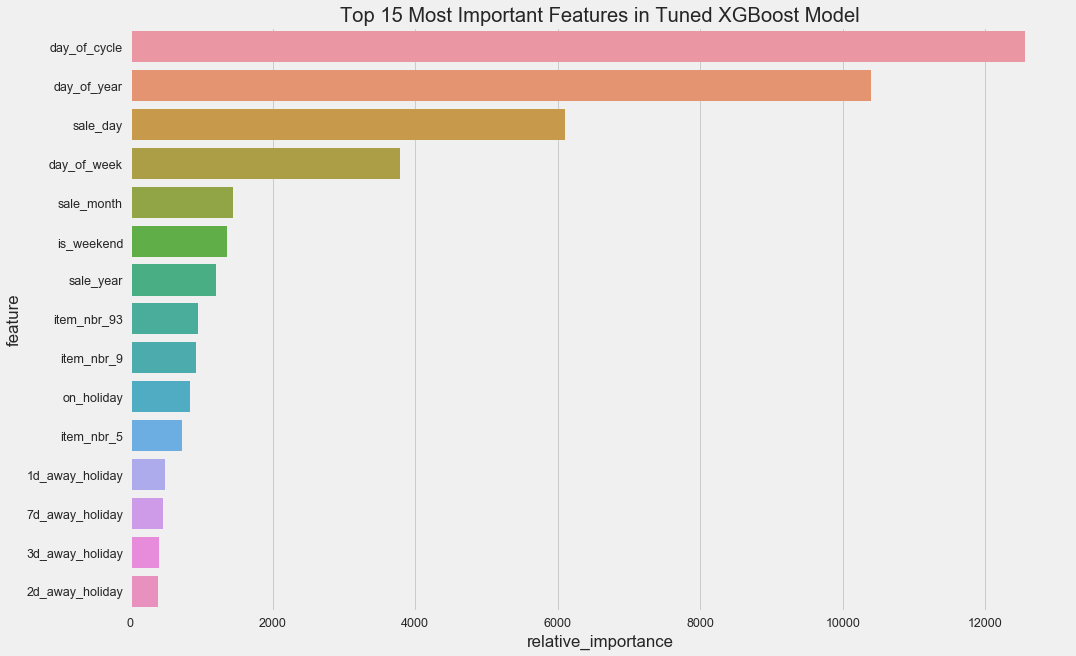

In [56]:
top_15_features=pd.DataFrame.from_dict(clf.booster().get_score(importance_type='weight'),orient='index').sort_values([0],ascending=False).head(15).reset_index()
top_15_features.columns=['feature','relative_importance']
plt.figure(figsize=(15,10))
plt.title("Top 15 Most Important Features in Tuned XGBoost Model")
sns.barplot(y='feature',x='relative_importance',data=top_15_features,orient='h')

# Part IV: Discussion of Results
I tried out several variations of different features before finally arriving on this particular set. In one variation, I converted each individual date to a dummy variable, but this tended to overfit the model on the training data. I also experimented with using using the target feature, units, in log, square root, and raw forms to see if the model would be predict on different transformations better. Without tuning, the default xgboost model worked better with units_sqrt. However, after tuning, the model performs better with units_log. 
All in all, I am content with the results of the model, given the fact that I worked on this project for 4 days. My main take-away is that tuning xgboost, even though it may take a couple hours, can really boost the performance of the default model, and in this case, without overfitting the training data either.

##### Competition Results: xgboost tuned scores a .09279 RMSLE Score 
<img src="https://i.imgur.com/MotfNgu.png" alt="Results" title="Results" />
